In [4]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import lmfit as lm

from functions import *
from alias import *

# fontsizes
plt.rcParams['font.size'] = 13
plt.rcParams['axes.labelsize'] = 16

## Load data

In [5]:
# instrument resolution
from data.instrument_resolution import  FWHM

In [6]:
###### IMPORT and REDUCE DATA ######
red = {}
for T in [160, 200, 300]:
    red[T] = pd.read_csv(f'./data/reddata/red_{T}K.csv')
    print(f'Loaded reduced data for {T}K')

Loaded reduced data for 160K
Loaded reduced data for 200K
Loaded reduced data for 300K


# Models

$$
L(Q, \omega) =  \frac{I_0(Q)}{\pi} \frac{\Gamma_0(Q)}{\omega^2 + \Gamma_0(Q)^2}
$$

$$
DHO_x(\omega) = \frac{I_x(Q)}{\pi} \frac{2\Gamma_x(Q)\Omega(Q)^2}{(\omega^2 - \Omega_x(Q)^2)^2 + 4\Gamma_x(Q)^2\omega_x(Q)^2}
$$

$$
S(Q, \omega) = (n(\omega)+1)\frac{\omega}{k_B T}[L(Q, \omega) + \sum_x DHO_x(Q, \omega)]
$$

$$
n(\omega) = \frac{1}{e^{\frac{\omega}{k_B T}} - 1}
$$

In [7]:
L = lambda omega, I0, Gamma0: I0/np.pi * (Gamma0 / (omega**2 + Gamma0**2))
DHO = lambda omega, Ix, Gammax, Omegax: Ix/np.pi * (2*Gammax*Omegax**2) / ((omega**2 - Omegax**2)**2 + 4*Gammax**2*omega**2)
eps = 0.1
delta = lambda omega, I0: I0/np.sqrt(2*np.pi)/eps * np.exp(-omega**2/(2*eps**2))
gauss = lambda omega, I0, sigma: I0/np.sqrt(2*np.pi)/sigma * np.exp(-omega**2/(2*sigma**2))

In [8]:
# Population factor
kB = 8.617333262e-2 # meV/K
eps = .000001
d_balance = lambda omega, T: (omega+eps)/(kB*T) * (1/(np.exp((omega+eps) / (kB*T)) - 1) + 1)

In [9]:
sigma_res = FWHM/2.355

In [10]:
##############
T = 160
##############

# 1) Delta + DHO

$$
S(Q, \omega) = (n(E)+1)\frac{E}{k_B T}[\delta(Q, \omega) + DHO_1(Q, \omega)]
$$
$$
=(n(E)+1)\frac{E}{k_B T} [ I_0 \delta(\omega)+ \frac{I_1}{\pi} \frac{2\Gamma_1\Omega^2}{(\omega^2 - \Omega^2)^2 + 4\Gamma_1^2\omega^2} ]
$$



In [11]:
######################################
########## Define the model ##########
######################################
S = lambda omega, T, omega0, I0, I1, Omega1, Gamma1: d_balance(omega-omega0, T) * (delta((omega-omega0), I0) + DHO((omega-omega0), I1, Gamma1, Omega1))
S_nodelta = lambda omega, T, omega0, I0, I1, Omega1, Gamma1: d_balance(omega-omega0, T) * (DHO((omega-omega0), I1, Gamma1, Omega1))
# We already removed from the mesuremts the k'/k factor! (that is np.sqrt((E_i-(omega))/E_i))

#######################################
########## Model convolution ##########
#######################################
S_conv     = lambda omega, T, omega0, I0, I1, Omega1, Gamma1: gauss_conv(omega-omega0, (T, omega0, I0, I1, Omega1, Gamma1), S_nodelta, sigma_res) + gauss(omega-omega0, I0, sigma_res)

S_delta_conv   = lambda omega, T, omega0, I0, I1, Omega1, Gamma1: gauss(omega-omega0, I0, sigma_res)

S_DHO      = lambda omega, T, omega0, I0, I1, Omega1, Gamma1: d_balance(omega-omega0, T) * DHO((omega-omega0), I1, Gamma1, Omega1)
S_DHO_conv = lambda omega, T, omega0, I0, I1, Omega1, Gamma1: gauss_conv(omega-omega0, (T, omega0, I0, I1, Omega1, Gamma1), S_DHO, sigma_res)

## Single spectrum analysis

In [12]:
##############
q = .7
##############

In [13]:
###### DATA ######
spec = get_spec(red[T], q)

###### MODEL ######
model = lm.Model(S_conv)
params = lm.Parameters()

Text(0.5, 0, 'Energy (meV)')

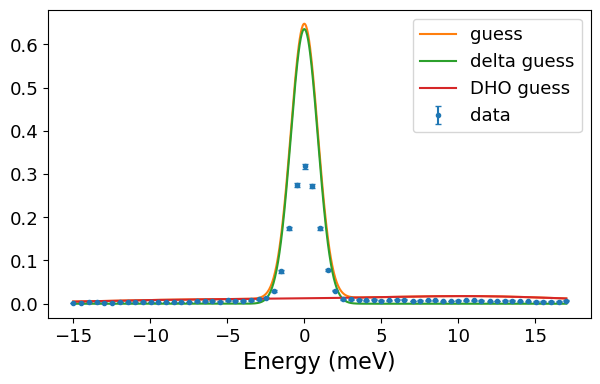

In [14]:
######################################
######### INITIAL PARAMETERS #########
######################################
params.add('T', value=T, vary=False)
params.add('omega0', value=0, min=-.2, max=.2)
params.add('I0', value=1.4, min=0, max=10)
params.add('I1', value=.5, min=0, max=10)
params.add('Omega1', value=16, min=0, max=40)
params.add('Gamma1', value=10, min=0, max=30)

######################################
############## GUESS PLOT ############
######################################
plt.figure(figsize=(7, 4))
plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')

X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
plt.plot(X, model.eval(params, omega=X), label='guess')
plt.plot(X, S_delta_conv(X, **params.valuesdict()), label='delta guess')
plt.plot(X, S_DHO_conv(X, **params.valuesdict()), label='DHO guess')

plt.legend()
plt.xlabel('Energy (meV)')

In [15]:
#######################
###### FIT MODEL ######
#######################
results = model.fit(spec.S, params, omega=spec.omega, weights=1/spec.dS)
display(results.params)

name,value,standard error,relative error,initial value,min,max,vary
T,160.000000,0.00000000,(0.00%),160,-inf,inf,False
omega0,0.01120204,0.00846665,(75.58%),0,-0.20000000,0.20000000,True
I0,0.68239497,0.00645960,(0.95%),1.4,0.00000000,10.0000000,True
I1,0.27258727,0.05827005,(21.38%),0.5,0.00000000,10.0000000,True
Omega1,24.7406499,18.5693793,(75.06%),16,0.00000000,40.0000000,True
Gamma1,28.9524043,38.3960715,(132.62%),10,0.00000000,30.0000000,True


Text(0.5, 0, 'Energy (meV)')

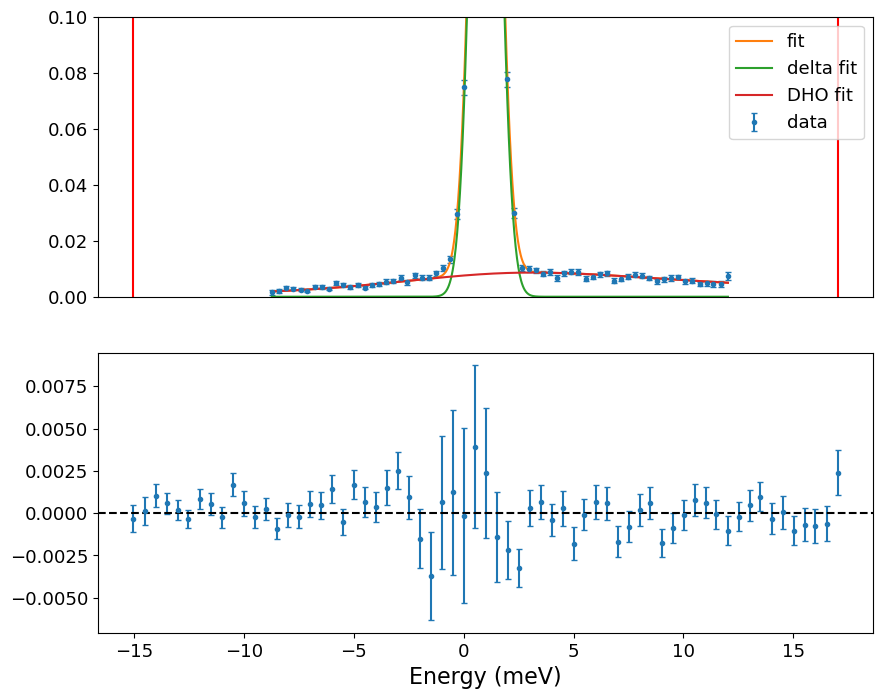

In [16]:
################################
######### PLOT THE FIT #########
################################
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')

X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
plt.plot(X, S_conv(X, **results.params.valuesdict()), label='fit')
plt.plot(X, S_delta_conv(X, **results.params.valuesdict()), label='delta fit')
plt.plot(X, S_DHO_conv(X, **results.params.valuesdict()), label='DHO fit')

plt.axvline(results.params.valuesdict()['Omega1'], c='r')
plt.axvline(-results.params.valuesdict()['Omega1'], c='r')


plt.legend()
plt.xticks([])
#plt.yscale('log')
plt.ylim(0,0.1)

### residual plot
plt.subplot(2,1,2)
plt.errorbar(spec.omega, spec.S - results.best_fit, yerr=spec.dS, fmt='.', capsize=2, label='residual')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Energy (meV)')

## Run over all Q

Fitting q=0.5, T=160K


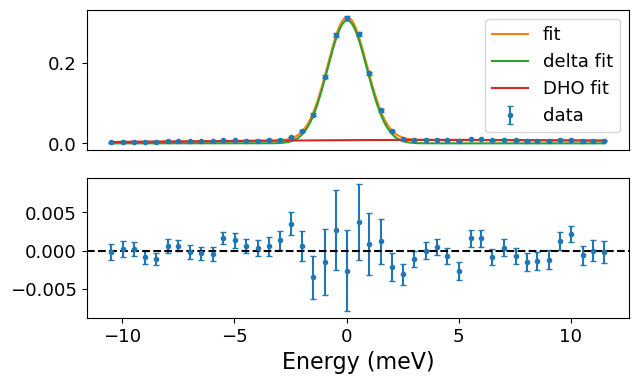

Fitting q=0.7, T=160K


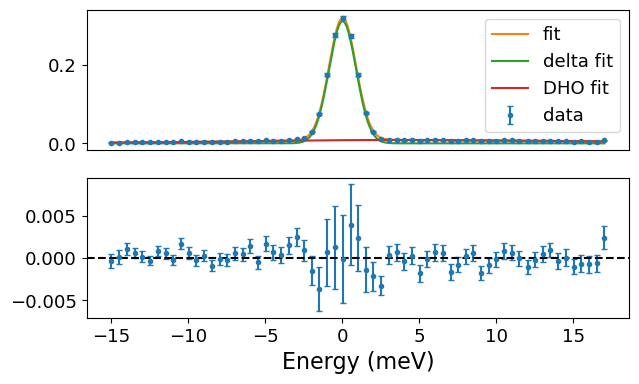

Fitting q=0.9, T=160K


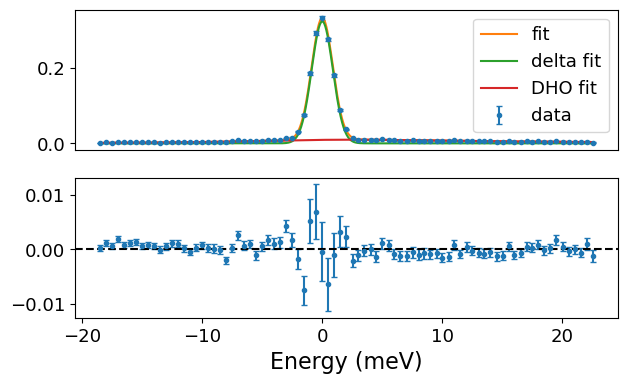

Fitting q=1.1, T=160K


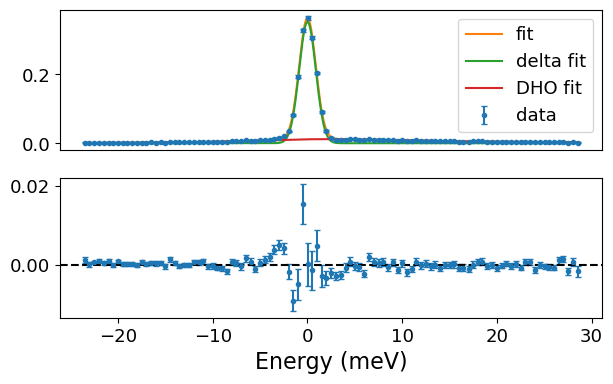

Fitting q=1.5, T=160K


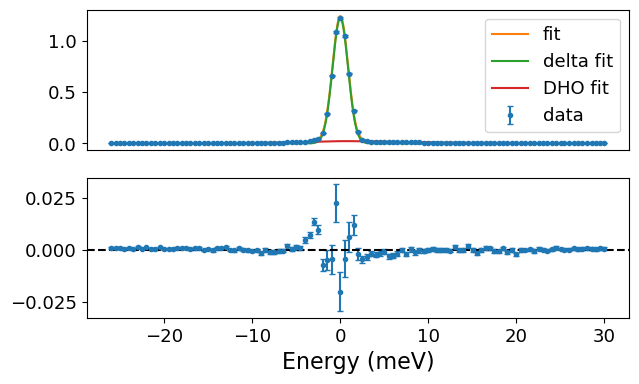

In [17]:
######################################
######### INITIAL PARAMETERS #########
######################################
model = lm.Model(S_conv)
params = lm.Parameters()

params.add('T', value=T, vary=False)
params.add('omega0', value=0, min=-.2, max=.2)
params.add('I0', value=1, min=0, max=10)
params.add('I1', value=1, min=0, max=10)
params.add('Omega1', value=10, min=0, max=30)
params.add('Gamma1', value=10, min=0, max=40)


fitout = {}
for q in Qs:
    print(f'Fitting q={q}, T={T}K')

    ###### FIT MODEL ######
    spec = get_spec(red[T], q)
    results = model.fit(spec.S, params, omega=spec.omega, weights=1/spec.dS)
    results.params = results.params
    fitout[T,q] = results.params

    ######### PLOT THE FIT #########
    plt.figure(figsize=(7, 4))
    plt.subplot(2,1,1)
    plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')
    X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
    plt.plot(X, S_conv(X, **results.params.valuesdict()), label='fit')
    plt.plot(X, S_delta_conv(X, **results.params.valuesdict()), label='delta fit')
    plt.plot(X, S_DHO_conv(X, **results.params.valuesdict()), label='DHO fit')
    plt.legend()
    plt.xticks([])
    #plt.yscale('log')
    #plt.ylim(1e-4, 1)

    ### residual plot
    plt.subplot(2,1,2)
    plt.errorbar(spec.omega, spec.S - results.best_fit, yerr=spec.dS, fmt='.', capsize=2, label='residual')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Energy (meV)')

    plt.show()

### SAVE RESULTS
omega0 = [fitout[T,q]['omega0'].value for q in Qs]
domega0 = [fitout[T,q]['omega0'].stderr for q in Qs]
I0 = [fitout[T,q]['I0'].value for q in Qs]
dI0 = [fitout[T,q]['I0'].stderr for q in Qs]
I1 = [fitout[T,q]['I1'].value for q in Qs]
dI1 = [fitout[T,q]['I1'].stderr for q in Qs]

Omega1 = [fitout[T,q]['Omega1'].value for q in Qs]
dOmega1 = [fitout[T,q]['Omega1'].stderr for q in Qs]
Gamma1 = [fitout[T,q]['Gamma1'].value for q in Qs]
dGamma1 = [fitout[T,q]['Gamma1'].stderr for q in Qs]

fitout = pd.DataFrame({'omega0':omega0, 'domega0':domega0, 'I0':I0, 'dI0':dI0, 'I1':I1, 'dI1':dI1, 'Omega1':Omega1, 'dOmega1':dOmega1, 'Gamma1':Gamma1, 'dGamma1':dGamma1}, index=Qs)
fitout.fillna(0, inplace=True)

c0 = 8.54 meV
c1 = 18.10 meV
c1/c0 = 2.12


(0.0, 43.99999997555391)

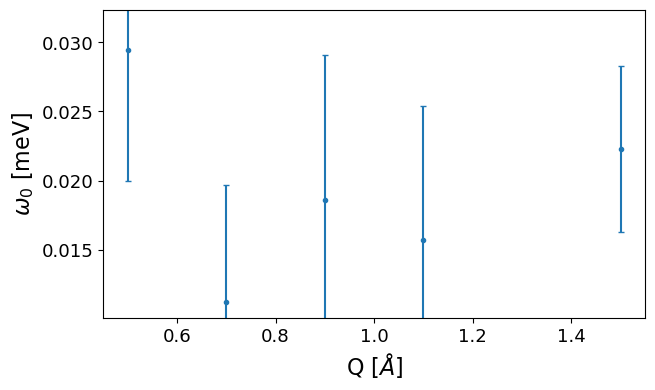

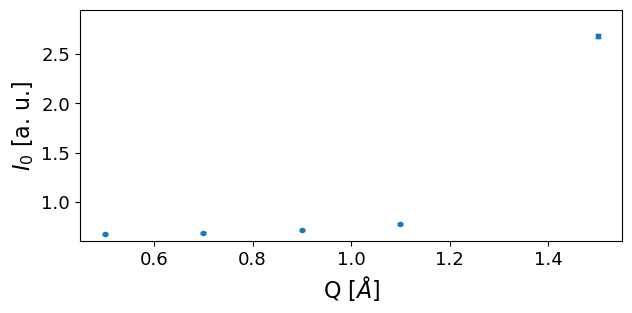

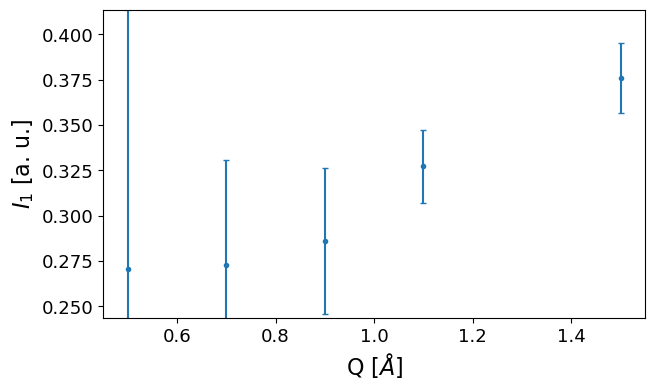

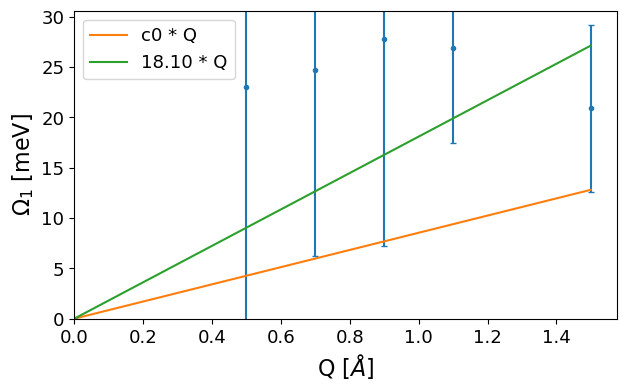

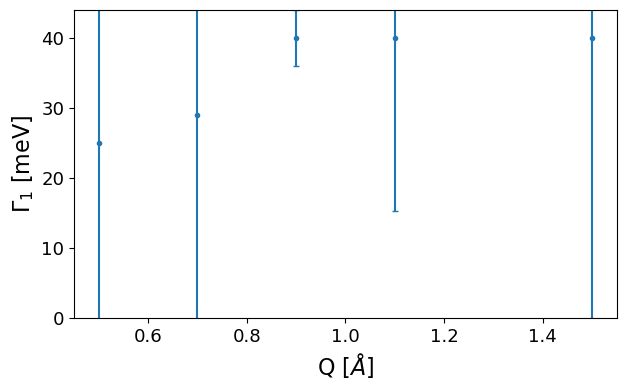

In [18]:
###########################
#### PLOT FIT RESULTS #####
###########################

### omega0 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.omega0, yerr=fitout.domega0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\omega_0$ [meV]')
plt.ylim(np.min(fitout.omega0)*.9, np.max(fitout.omega0)*1.1)

### I0 ###
plt.figure(figsize=(7, 3))
plt.errorbar(Qs, fitout.I0, yerr=fitout.dI0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$I_0$ [a. u.]')
plt.ylim(np.min(fitout.I0)*.9, np.max(fitout.I0)*1.1)

### I1 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.I1, yerr=fitout.dI1, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$I_1$ [a. u.]')
plt.ylim(np.min(fitout.I1)*.9, np.max(fitout.I1)*1.1)

### Omega1 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.Omega1, yerr=fitout.dOmega1, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Omega_1$ [meV]')
plt.ylim(0, np.max(fitout.Omega1)*1.1)
# plot of c0
X = np.linspace(0, Qs[-1], 1000)
c0 = 1298 * 6.58e-3
plt.plot(X, c0*X, label='c0 * Q')
# fit to c1
linear = lambda x, a: a*x
p, V = curve_fit(linear, Qs, np.array(fitout.Omega1), sigma=np.array(fitout.dOmega1), absolute_sigma=True)
plt.plot(X, linear(X, *p), label=f'{p[0]:.2f} * Q')
print(f'c0 = {c0:.2f} meV')
print(f'c1 = {p[0]:.2f} meV')
print(f'c1/c0 = {p[0]/c0:.2f}')

plt.xlim(0)
plt.legend()

### Gamma1 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.Gamma1, yerr=fitout.dGamma1, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Gamma_1$ [meV]')
plt.ylim(0, np.max(fitout.Gamma1)*1.1)

# 2) L + DHO

$$
S(Q, \omega) = \frac{k_f}{k_i} (n(E)+1)\frac{E}{k_B T}[L(Q, \omega) + DHO_0(Q, \omega)]
$$
$$
= \frac{k_f}{k_i} (n(E)+1)\frac{E}{k_B T} [ \frac{I_0}{\pi} \frac{\Gamma_0}{\omega^2 + \Gamma_0^2} + \frac{I_1}{\pi} \frac{2\Gamma_1\Omega^2}{(\omega^2 - \Omega^2)^2 + 4\Gamma_1^2\omega^2} ]
$$



In [19]:
######################################
########## Define the model ##########
######################################
S = lambda omega, T, omega0, I0, Gamma0, I1, Omega1, Gamma1: d_balance(omega-omega0, T) * (L((omega-omega0), I0, Gamma0) + DHO((omega-omega0), I1, Gamma1, Omega1))
# We already removed from the mesuremts the k'/k factor! (that is np.sqrt((E_i-(omega))/E_i))

#######################################
########## Model convolution ##########
#######################################
S_conv     = lambda omega, T, omega0, I0, Gamma0, I1, Omega1, Gamma1: gauss_conv(omega-omega0, (T, omega0, I0, Gamma0, I1, Omega1, Gamma1), S, sigma_res)

S_DHO      = lambda omega, T, omega0, I0, Gamma0, I1, Omega1, Gamma1: d_balance(omega-omega0, T) * DHO((omega-omega0), I1, Gamma1, Omega1)
S_DHO_conv = lambda omega, T, omega0, I0, Gamma0, I1, Omega1, Gamma1: gauss_conv(omega-omega0, (T, omega0, I0, Gamma0, I1, Omega1, Gamma1), S_DHO, sigma_res)

S_L        = lambda omega, T, omega0, I0, Gamma0, I1, Omega1, Gamma1: d_balance(omega-omega0, T) * L((omega-omega0), I0, Gamma0)
S_L_conv   = lambda omega, T, omega0, I0, Gamma0, I1, Omega1, Gamma1: gauss_conv(omega-omega0, (T, omega0, I0, Gamma0, I1, Omega1, Gamma1), S_L, sigma_res)

## Single spectrum

In [20]:
##############
q = .5
##############

In [21]:
###### DATA ######
spec = get_spec(red[T], q)

###### MODEL ######
model = lm.Model(S_conv)
params = lm.Parameters()

Text(0.5, 0, 'Energy (meV)')

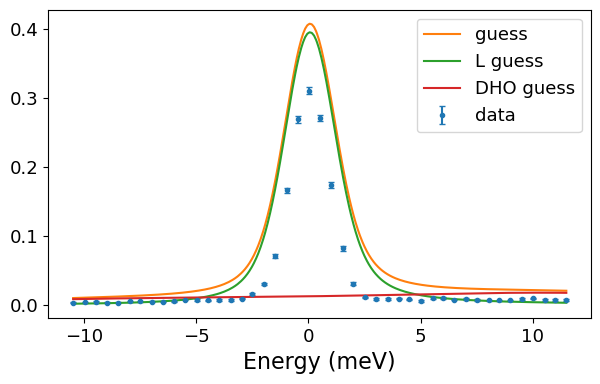

In [22]:
######################################
######### INITIAL PARAMETERS #########
######################################
params.add('T', value=T, vary=False)
params.add('omega0', value=0.000, min=-0.2, max=.2)
params.add('I0', value=1.4, min=0, max=10)
params.add('Gamma0', value=.6, min=0, max=4)
params.add('I1', value=.5, min=0, max=10)
params.add('Omega1', value=16, min=0, max=40)
params.add('Gamma1', value=10, min=0, max=30)

######################################
############## GUESS PLOT ############
######################################
plt.figure(figsize=(7, 4))
plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')

X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
plt.plot(X, model.eval(params, omega=X), label='guess')
plt.plot(X, S_L_conv(X, **params.valuesdict()), label='L guess')
plt.plot(X, S_DHO_conv(X, **params.valuesdict()), label='DHO guess')

plt.legend()
plt.xlabel('Energy (meV)')

In [23]:
#################
### FIT MODEL ###
#################
results = model.fit(spec.S, params, omega=spec.omega, weights=1/spec.dS)
display(results.params)

name,value,standard error,relative error,initial value,min,max,vary
T,160.000000,0.00000000,(0.00%),160,-inf,inf,False
omega0,-0.00875071,0.00542587,(62.00%),0.0,-0.20000000,0.20000000,True
I0,9.99997142,1573.35626,(15733.61%),1.4,0.00000000,10.0000000,True
Gamma0,0.00204932,0.42071253,(20529.35%),0.6,0.00000000,4.00000000,True
I1,0.19658994,0.03948393,(20.08%),0.5,0.00000000,10.0000000,True
Omega1,12.7843482,3.68322667,(28.81%),16,0.00000000,40.0000000,True
Gamma1,8.62438988,4.50378391,(52.22%),10,0.00000000,30.0000000,True


Text(0.5, 0, 'Energy (meV)')

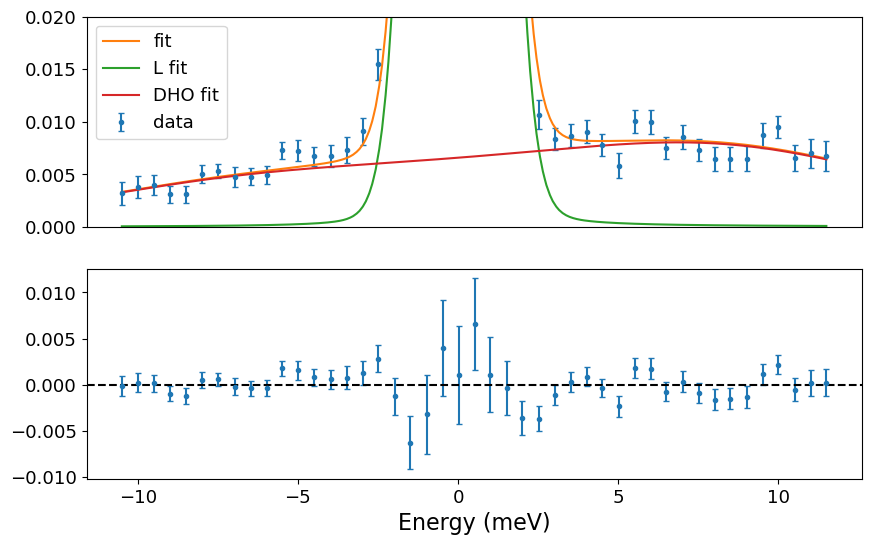

In [24]:
################################
######### PLOT THE FIT #########
################################
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')

X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
plt.plot(X, S_conv(X, **results.params.valuesdict()), label='fit')
plt.plot(X, S_L_conv(X, **results.params.valuesdict()), label='L fit')
plt.plot(X, S_DHO_conv(X, **results.params.valuesdict()), label='DHO fit')

plt.legend()
plt.xticks([])
#plt.yscale('log')
plt.ylim(0,0.02)

# residual plot
plt.subplot(2,1,2)
plt.errorbar(spec.omega, spec.S - results.best_fit, yerr=spec.dS, fmt='.', capsize=2, label='residual')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Energy (meV)')

## Run over all Q

Fitting q=0.5, T=160K


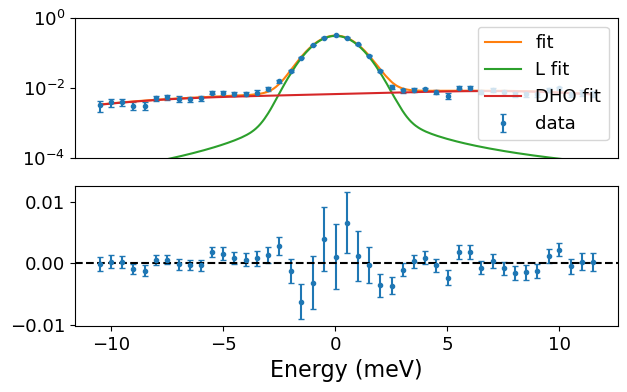

Fitting q=0.7, T=160K


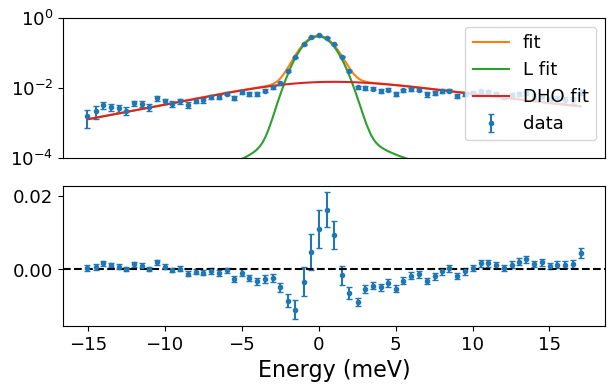

Fitting q=0.9, T=160K


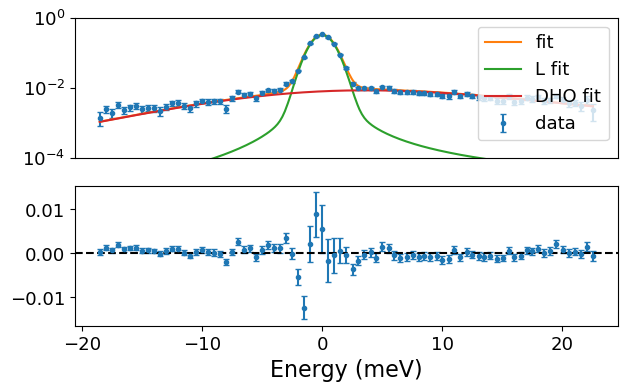

Fitting q=1.1, T=160K


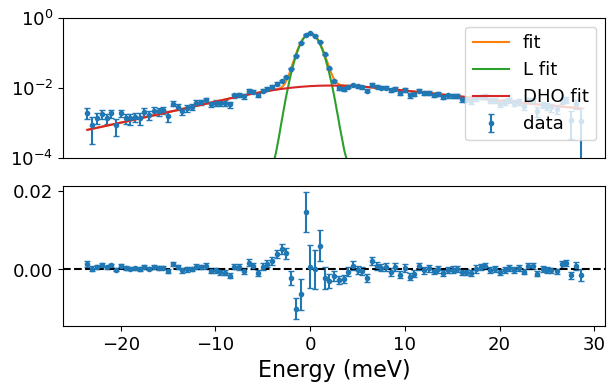

Fitting q=1.5, T=160K


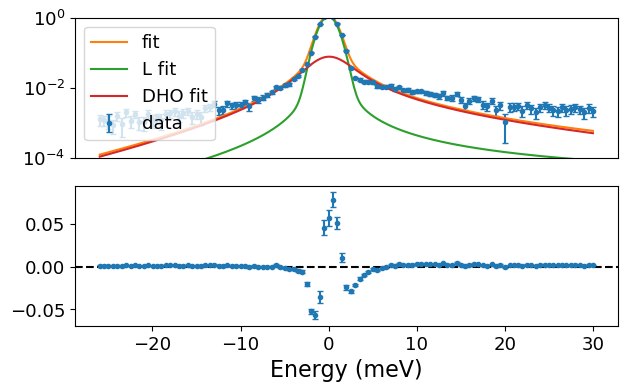

In [28]:
######################################
######### INITIAL PARAMETERS #########
######################################
model = lm.Model(S_conv)
params = lm.Parameters()

params.add('T', value=T, vary=False)
params.add('omega0', value=0, min=-0.2, max=0.2)
params.add('I0', value=1, min=0, max=10)
params.add('Gamma0', value=.5, min=0, max=4)
params.add('I1', value=1, min=0, max=10)
params.add('Omega1', value=10, min=0, max=30)
params.add('Gamma1', value=10, min=0, max=30)


fitout = {}
for q in Qs:
    print(f'Fitting q={q}, T={T}K')

    ###### FIT MODEL ######
    spec = get_spec(red[T], q)
    results = model.fit(spec.S, params, omega=spec.omega, weights=1/spec.dS)
    fitout[T,q] = results.params

    ######### PLOT THE FIT #########
    plt.figure(figsize=(7, 4))
    plt.subplot(2,1,1)
    plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')
    X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
    plt.plot(X, S_conv(X, **results.params.valuesdict()), label='fit')
    plt.plot(X, S_L_conv(X, **results.params.valuesdict()), label='L fit')
    plt.plot(X, S_DHO_conv(X, **results.params.valuesdict()), label='DHO fit')
    plt.legend()
    plt.xticks([])
    plt.yscale('log')
    plt.ylim(1e-4, 1)

    ### residual plot
    plt.subplot(2,1,2)
    plt.errorbar(spec.omega, spec.S - results.best_fit, yerr=spec.dS, fmt='.', capsize=2, label='residual')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Energy (meV)')

    plt.show()
    

### SAVE RESULTS
omega0 = [fitout[T,q]['omega0'].value for q in Qs]
domega0 = [fitout[T,q]['omega0'].stderr for q in Qs]
I0 = [fitout[T,q]['I0'].value for q in Qs]
dI0 = [fitout[T,q]['I0'].stderr for q in Qs]
Gamma0 = [fitout[T,q]['Gamma0'].value for q in Qs]
dGamma0 = [fitout[T,q]['Gamma0'].stderr for q in Qs]
I1 = [fitout[T,q]['I1'].value for q in Qs]
dI1 = [fitout[T,q]['I1'].stderr for q in Qs]
Omega1 = [fitout[T,q]['Omega1'].value for q in Qs]
dOmega1 = [fitout[T,q]['Omega1'].stderr for q in Qs]
Gamma1 = [fitout[T,q]['Gamma1'].value for q in Qs]
dGamma1 = [fitout[T,q]['Gamma1'].stderr for q in Qs]

fitout = pd.DataFrame({'omega0':omega0, 'domega0':domega0, 'I0':I0, 'dI0':dI0, 'Gamma0':Gamma0, 'dGamma0':dGamma0, 'I1':I1, 'dI1':dI1, 'Omega1':Omega1, 'dOmega1':dOmega1, 'Gamma1':Gamma1, 'dGamma1':dGamma1}, index=Qs)
fitout.fillna(0, inplace=True)

In [26]:
# save fitout to csv
fitout.to_csv(f'./data/fit_out/L+DHO_{T}K.csv')

c1/c0 = 0.01


(0.0, 1.55)

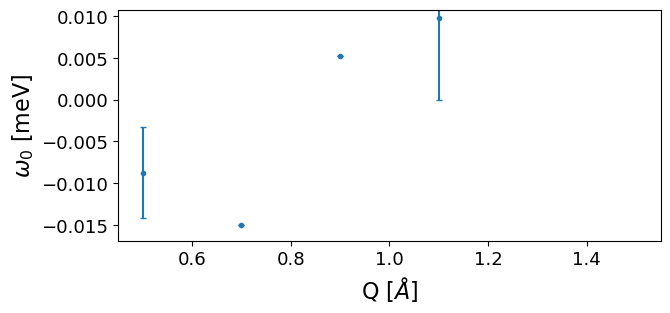

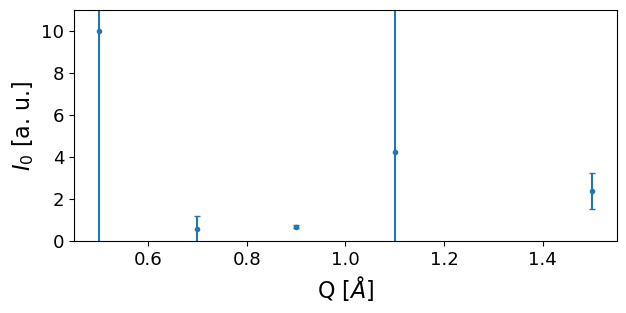

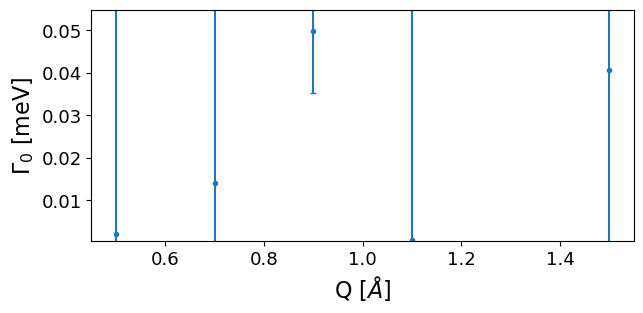

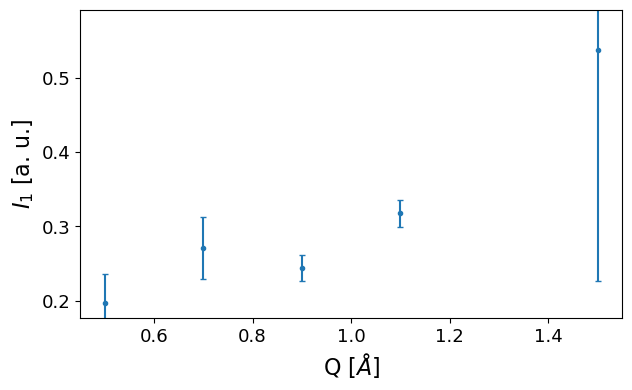

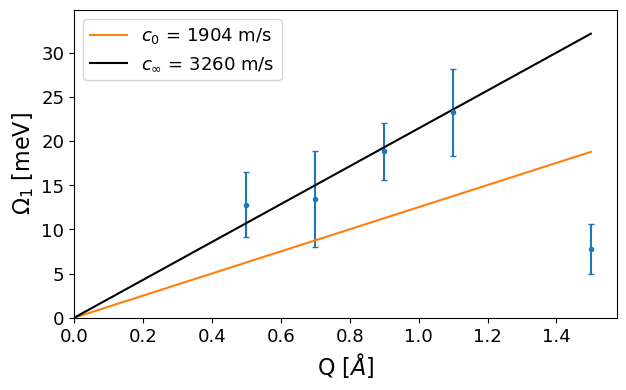

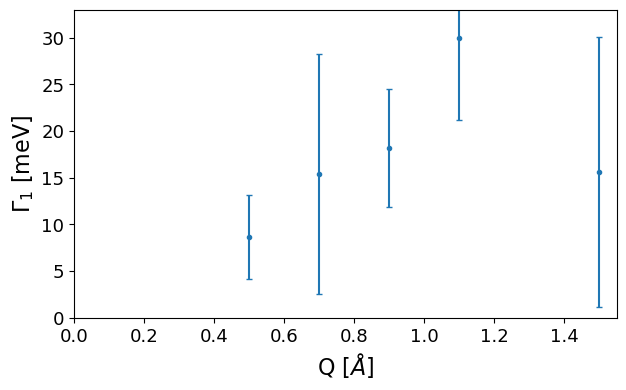

In [27]:
###########################
#### PLOT FIT RESULTS #####
###########################

### omega0 ###
plt.figure(figsize=(7, 3))
plt.errorbar(Qs, fitout.omega0, yerr=fitout.domega0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\omega_0$ [meV]')
plt.ylim(np.min(fitout.omega0)*.9, np.max(fitout.omega0)*1.1)

### I0 ###
plt.figure(figsize=(7, 3))
plt.errorbar(Qs, fitout.I0, yerr=fitout.dI0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$I_0$ [a. u.]')
plt.ylim(np.min(fitout.I0)*.9, np.max(fitout.I0)*1.1)
plt.ylim(0)

### Gamma0 ###
plt.figure(figsize=(7, 3))
plt.errorbar(Qs, fitout.Gamma0, yerr=fitout.dGamma0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Gamma_0$ [meV]')
plt.ylim(np.min(fitout.Gamma0)*.9, np.max(fitout.Gamma0)*1.1)

### I1 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.I1, yerr=fitout.dI1, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$I_1$ [a. u.]')
plt.ylim(np.min(fitout.I1)*.9, np.max(fitout.I1)*1.1)

### Omega1 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.Omega1, yerr=fitout.dOmega1, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Omega_1$ [meV]')
plt.ylim(0, np.max(fitout.Omega1)*1.5)

# plot if c0
X = np.linspace(0, Qs[-1], 1000)
c0 = 1904
plt.plot(X, c0* 6.58e-3*X, label=f'$c_0$ = {c0} m/s')

# fit to c1
linear = lambda x, a: a*x
p, V = curve_fit(linear, Qs[0:3], np.array(fitout.Omega1)[0:3], sigma=np.array(fitout.dOmega1)[0:3], absolute_sigma=True)
plt.plot(X, linear(X, *p), label=f'$c_\infty$ = {p[0]/6.58e-3:.0f} m/s', c='k')

print(f'c1/c0 = {p[0]/c0:.2f}')
plt.xlim(0)
plt.legend()

### Gamma1 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.Gamma1, yerr=fitout.dGamma1, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Gamma_1$ [meV]')
plt.ylim(0, np.max(fitout.Gamma1)*1.1)
plt.xlim(0)

# 3) delta + DHO + DHO

$$
S(Q, \omega) = (n(E)+1)\frac{E}{k_B T}[\delta(Q, \omega) + DHO_1(Q, \omega) + DHO_2(Q, \omega)]
$$
$$
=  (n(E)+1)\frac{E}{k_B T} [ I_0\delta(\omega) + \frac{I_1}{\pi} \frac{2\Gamma_1\Omega^2}{(\omega^2 - \Omega^2)^2 + 4\Gamma_1^2\omega^2} + \frac{I_2}{\pi} \frac{2\Gamma_2\Omega^2}{(\omega^2 - \Omega^2)^2 + 4\Gamma_2^2\omega^2} ]
$$



In [73]:
######################################
########## Define the model ##########
######################################
S = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: d_balance(omega-omega0, T) * (delta((omega-omega0), I0) + DHO((omega-omega0), I1, Gamma1, Omega1) + DHO((omega-omega0), I2, Gamma2, Omega2))
S_nodelta = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: d_balance(omega-omega0, T) * (DHO((omega-omega0), I1, Gamma1, Omega1) + DHO((omega-omega0), I2, Gamma2, Omega2))

#######################################
########## Model convolution ##########
#######################################
S_conv       = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: gauss_conv(omega-omega0, (T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2), S_nodelta, sigma_res) + gauss(omega-omega0, I0, sigma_res)
S_delta_conv = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: gauss(omega-omega0, I0, sigma_res)

S_DHO1       = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: d_balance(omega-omega0, T) * DHO((omega-omega0), I1, Gamma1, Omega1)
S_DHO1_conv  = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: gauss_conv(omega-omega0, (T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2), S_DHO1, sigma_res)

S_DHO2       = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: d_balance(omega-omega0, T) * DHO((omega-omega0), I2, Gamma2, Omega2)
S_DHO2_conv  = lambda omega, T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2: gauss_conv(omega-omega0, (T, omega0, I0, I1, Omega1, Gamma1, I2, Omega2, Gamma2), S_DHO2, sigma_res)


## Single spectrum

In [74]:
##############
q = 1.5
##############

In [75]:
###### DATA ######
spec = get_spec(red[T], q)

###### MODEL ######
model = lm.Model(S_conv)
params = lm.Parameters()

Text(0.5, 0, 'Energy (meV)')

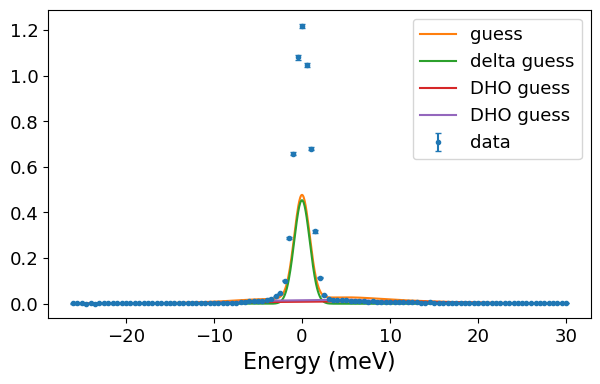

In [76]:
######################################
######### INITIAL PARAMETERS #########
######################################
params.add('T', value=T, vary=False)
params.add('omega0', value=0, min=-.2, max=.2)
params.add('I0', value=1, min=0, max=10)
params.add('I1', value=.3, min=0, max=1.5)
params.add('Omega1', value=15, min=5, max=40)
params.add('Gamma1', value=10, min=0, max=30)
params.add('I2', value=.3, min=0, max=1.5)
params.add('Omega2', value=8, min=5, max=40)
params.add('Gamma2', value=5, min=0, max=30)

######################################
############## GUESS PLOT ############
######################################
plt.figure(figsize=(7, 4))
plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')

X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
plt.plot(X, model.eval(params, omega=X), label='guess')
plt.plot(X, S_delta_conv(X, **params.valuesdict()), label='delta guess')
plt.plot(X, S_DHO1_conv(X, **params.valuesdict()), label='DHO guess')
plt.plot(X, S_DHO2_conv(X, **params.valuesdict()), label='DHO guess')

plt.legend()
plt.xlabel('Energy (meV)')

In [77]:
#######################
###### FIT MODEL ######
#######################
results = model.fit(spec.S, params, omega=spec.omega, weights=1/spec.dS)
display(results.params)

name,value,standard error,relative error,initial value,min,max,vary
T,160.000000,0.00000000,(0.00%),160,-inf,inf,False
omega0,0.02164407,0.00589300,(27.23%),0,-0.20000000,0.20000000,True
I0,2.67478079,0.02535396,(0.95%),1,0.00000000,10.0000000,True
I1,0.23196448,0.14581193,(62.86%),0.3,0.00000000,1.50000000,True
Omega1,24.7693596,9.57806650,(38.67%),15,5.00000000,40.0000000,True
Gamma1,29.9999563,31.6028980,(105.34%),10,0.00000000,30.0000000,True
I2,0.15398832,0.14119186,(91.69%),0.3,0.00000000,1.50000000,True
Omega2,5.00000002,0.61069302,(12.21%),8,5.00000000,40.0000000,True
Gamma2,3.98494710,4.19835841,(105.36%),5,0.00000000,30.0000000,True


Text(0.5, 0, 'Energy (meV)')

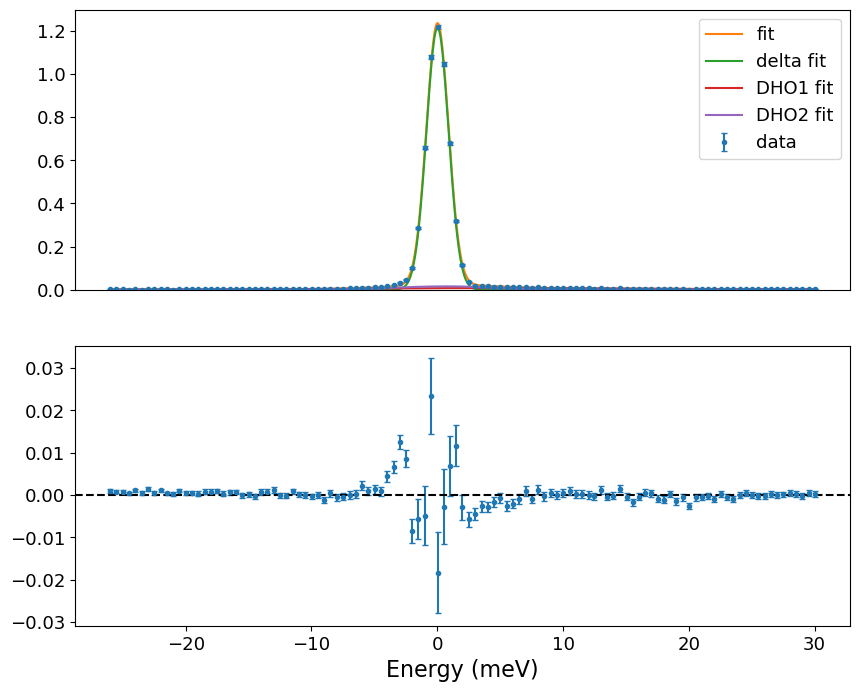

In [78]:
################################
######### PLOT THE FIT #########
################################
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')

X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
plt.plot(X, S_conv(X, **results.params.valuesdict()), label='fit')
plt.plot(X, S_delta_conv(X, **results.params.valuesdict()), label='delta fit')
plt.plot(X, S_DHO1_conv(X, **results.params.valuesdict()), label='DHO1 fit')
plt.plot(X, S_DHO2_conv(X, **results.params.valuesdict()), label='DHO2 fit')

plt.legend()
plt.xticks([])
#plt.yscale('log')
plt.ylim(0)

### residual plot
plt.subplot(2,1,2)
plt.errorbar(spec.omega, spec.S - results.best_fit, yerr=spec.dS, fmt='.', capsize=2, label='residual')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Energy (meV)')

## Run over all Q

Fitting q=0.5, T=160K


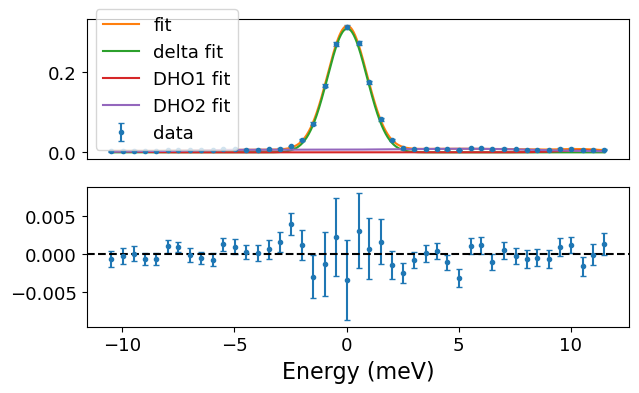

Fitting q=0.7, T=160K


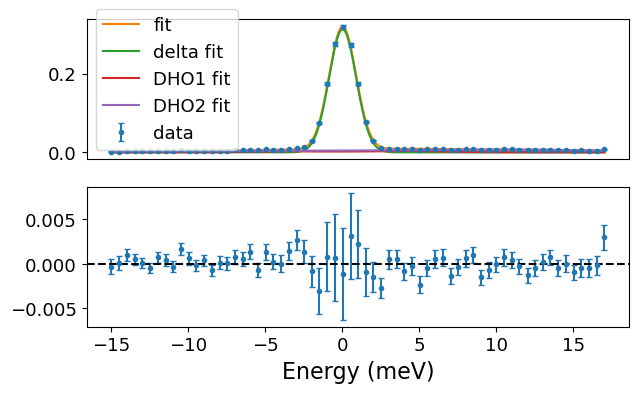

Fitting q=0.9, T=160K


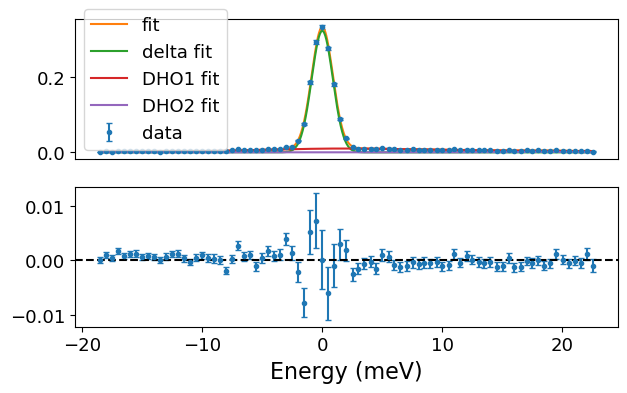

Fitting q=1.1, T=160K


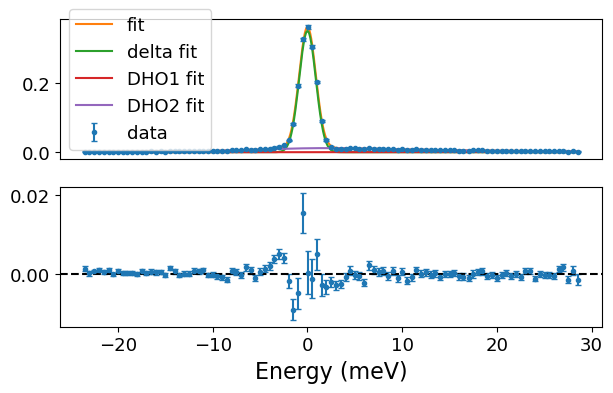

Fitting q=1.5, T=160K


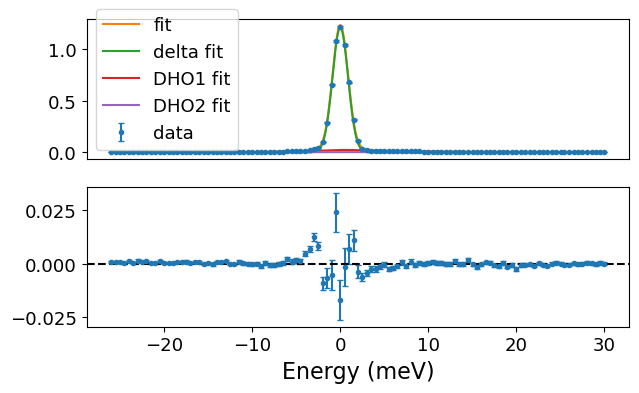

In [79]:
######################################
######### INITIAL PARAMETERS #########
######################################
model = lm.Model(S_conv)
params = lm.Parameters()

params.add('T', value=T, vary=False)
params.add('omega0', value=0, min=-.2, max=.2)
params.add('I0', value=1, min=.5, max=10)
params.add('I1', value=.5, min=0, max=10)
params.add('Omega1', value=10, min=4, max=40)
params.add('Gamma1', value=10, min=0, max=50)
params.add('I2', value=.5, min=0, max=10)
params.add('Omega2', value=7, min=4, max=40)
params.add('Gamma2', value=7, min=0, max=50)

fitout = {}
for q in Qs:
    print(f'Fitting q={q}, T={T}K')

    ###### FIT MODEL ######
    spec = get_spec(red[T], q)
    results = model.fit(spec.S, params, omega=spec.omega, weights=1/spec.dS)
    fitout[T,q] = results.params

    ######### PLOT THE FIT #########
    plt.figure(figsize=(7, 4))
    plt.subplot(2,1,1)
    plt.errorbar(spec.omega, spec.S, yerr=spec.dS, fmt='.', capsize=2, label='data')
    X = np.linspace(spec.omega.min(), spec.omega.max(), 1000)
    plt.plot(X, S_conv(X, **results.params.valuesdict()), label='fit')
    plt.plot(X, S_delta_conv(X, **results.params.valuesdict()), label='delta fit')
    plt.plot(X, S_DHO1_conv(X, **results.params.valuesdict()), label='DHO1 fit')
    plt.plot(X, S_DHO2_conv(X, **results.params.valuesdict()), label='DHO2 fit')

    plt.legend()
    plt.xticks([])
    #plt.yscale('log')


    ### residuals
    plt.subplot(2,1,2)
    plt.errorbar(spec.omega, spec.S - results.best_fit, yerr=spec.dS, fmt='.', capsize=2, label='residual')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Energy (meV)')

    plt.show()

### SAVE RESULTS
omega0 = [fitout[T,q]['omega0'].value for q in Qs]
domega0 = [fitout[T,q]['omega0'].stderr for q in Qs]
I0 = [fitout[T,q]['I0'].value for q in Qs]
dI0 = [fitout[T,q]['I0'].stderr for q in Qs]
I1 = [fitout[T,q]['I1'].value for q in Qs]
dI1 = [fitout[T,q]['I1'].stderr for q in Qs]
Omega1 = [fitout[T,q]['Omega1'].value for q in Qs]
dOmega1 = [fitout[T,q]['Omega1'].stderr for q in Qs]
Gamma1 = [fitout[T,q]['Gamma1'].value for q in Qs]
dGamma1 = [fitout[T,q]['Gamma1'].stderr for q in Qs]
I2 = [fitout[T,q]['I2'].value for q in Qs]
dI2 = [fitout[T,q]['I2'].stderr for q in Qs]
Omega2 = [fitout[T,q]['Omega2'].value for q in Qs]
dOmega2 = [fitout[T,q]['Omega2'].stderr for q in Qs]
Gamma2 = [fitout[T,q]['Gamma2'].value for q in Qs]
dGamma2 = [fitout[T,q]['Gamma2'].stderr for q in Qs]

fitout = pd.DataFrame({'omega0':omega0, 'domega0':domega0, 'I0':I0, 'dI0':dI0, 'I1':I1, 'dI1':dI1, 'Omega1':Omega1, 'dOmega1':dOmega1, 'Gamma1':Gamma1, 'dGamma1':dGamma1, 'I2':I2, 'dI2':dI2, 'Omega2':Omega2, 'dOmega2':dOmega2, 'Gamma2':Gamma2, 'dGamma2':dGamma2}, index=Qs)
fitout.fillna(0, inplace=True)

(0.0, 54.99997095952093)

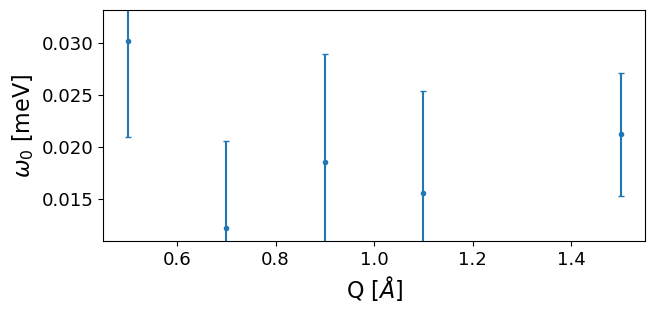

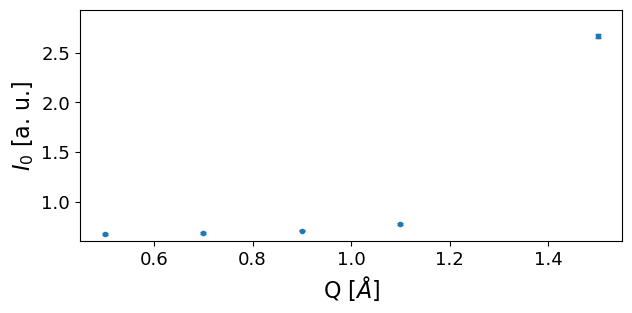

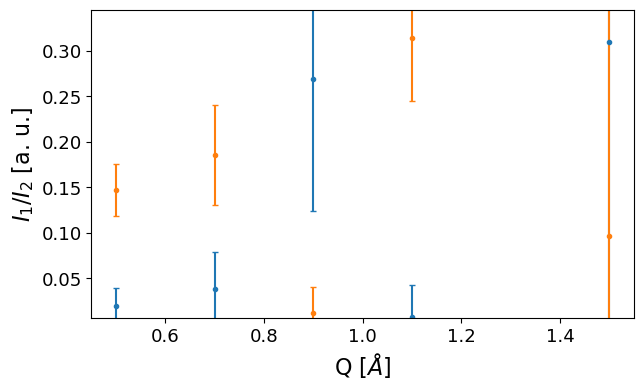

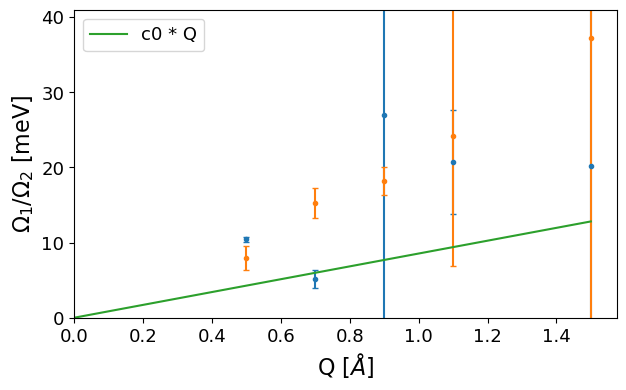

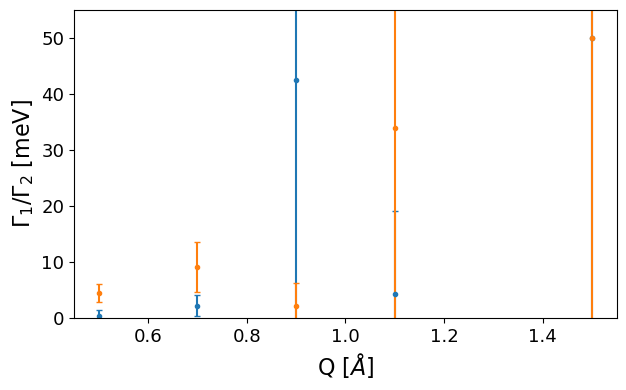

In [80]:
###########################
#### PLOT FIT RESULTS #####
###########################

### omega0 ###
plt.figure(figsize=(7, 3))
plt.errorbar(Qs, fitout.omega0, yerr=fitout.domega0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\omega_0$ [meV]')
plt.ylim(np.min(fitout.omega0)*.9, np.max(fitout.omega0)*1.1)

### I0 ###
plt.figure(figsize=(7, 3))
plt.errorbar(Qs, fitout.I0, yerr=fitout.dI0, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$I_0$ [a. u.]')
plt.ylim(np.min(fitout.I0)*.9, np.max(fitout.I0)*1.1)

### I1, I2 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.I1, yerr=fitout.dI1, fmt='.', capsize=2)
plt.errorbar(Qs, fitout.I2, yerr=fitout.dI2, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$I_1/I_2$ [a. u.]')
plt.ylim(np.min([fitout.I1, fitout.I2])*0.9, np.max([fitout.I1, fitout.I2])*1.1)

### Omega1, Omega2 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.Omega1, yerr=fitout.dOmega1, fmt='.', capsize=2)
plt.errorbar(Qs, fitout.Omega2, yerr=fitout.dOmega2, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Omega_1/\Omega_2$ [meV]')
plt.ylim(0, np.max([fitout.Omega1, fitout.Omega2])*1.1)
# plot of c0
X = np.linspace(0, max(Qs), 1000)
c0 = 1298 * 6.58e-3
plt.plot(X, c0*X, label='c0 * Q')

plt.xlim(0)
plt.legend()

### Gamma1, Gamma2 ###
plt.figure(figsize=(7, 4))
plt.errorbar(Qs, fitout.Gamma1, yerr=fitout.dGamma1, fmt='.', capsize=2)
plt.errorbar(Qs, fitout.Gamma2, yerr=fitout.dGamma2, fmt='.', capsize=2)
plt.xlabel('Q [$\AA$]')
plt.ylabel('$\Gamma_1/\Gamma_2$ [meV]')
plt.ylim(0, np.max([fitout.Gamma1, fitout.Gamma2])*1.1)